In [1]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re

In [2]:
Cnn1D = cnn.CNN1D

In [630]:
input_dir = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"
floor = 3
start_date = "2019-03-07"
end_date = "2019-12-31"
cut_date = "2019-05-08"
feature = "lux"
resample_method = "max"

In [631]:
floor_dict = createDictFloor(input_dir, f"Floor{floor}")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")
resample,scalers, index_nan = createDTFeat(start_date, end_date, floor_dict, feature,resample_method=resample_method)
cleanedData, remain_date = cleanNan(resample, index_nan)
for data in cleanedData.keys():
    zone = cleanedData[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("{} Dates: {}".format(data,len(np.unique(zone["date"]))))
    
getInfoTimeShape(cleanedData)

Floor3Z1 Start: 2019-03-06 13:44:00 End: 2019-12-31 23:59:00 Count:397115

Floor3Z2 Start: 2019-03-06 13:50:00 End: 2019-12-31 23:59:00 Count:414258

Floor3Z5 Start: 2019-03-06 13:52:00 End: 2019-12-31 23:59:00 Count:372916

Floor3Z4 Start: 2019-03-06 13:42:00 End: 2019-12-31 23:59:00 Count:421719

Floor3Z1 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor3Z1 Dates: 300
Floor3Z2 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor3Z2 Dates: 300
Floor3Z5 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor3Z5 Dates: 300
Floor3Z4 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor3Z4 Dates: 300
Floor : Floor3Z1 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor3Z2 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor3Z5 ,

In [632]:
train_date, test_date = splitDate(remain_date, cut_date)
databyDate = createDataByDate(cleanedData, feature, remain_date)
trainloader = []
testloder = []
nb_zone = 5
lookback = 13
lookahead = 1
batch_size=32
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        loaderZtrain = LoaderByZone(databyDate, zoneID, train_date, lookback, lookahead, batch_size, shuffle=True)
        loaderZtest = LoaderByZone(databyDate, zoneID, test_date, lookback, lookahead, batch_size)
        trainloader.append(loaderZtrain)
        testloder.append(loaderZtest)
zone_no=len(trainloader)

/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/DMFW/src/dataShaper.py:109: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


Zone Floor3Z1
Zone Floor3Z1
Zone Floor3Z2
Zone Floor3Z2
Zone Floor3Z4
Zone Floor3Z4
Zone Floor3Z5
Zone Floor3Z5


In [633]:
def LoaderByZoneNormal(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    firstday = data[dates[0]][zone_name]
    myX, myY = to_timeseries_input(firstday, lookback, lookahead)
    for date in dates[1:]:
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        myX = np.vstack((myX, trainx))
        myY = np.vstack((myY, trainy))
    xshape = torch.tensor(myX, dtype=torch.float).unsqueeze(-1)
    yshape = torch.tensor(myY, dtype=torch.float)
    tensorwrap = TensorDataset(xshape, yshape)
    loaderxy = DataLoader(tensorwrap, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return loaderxy

def gap_fn(grad, weight, radius):
    fw_gap = 0
    for grad_avg, weight in zip(grad, weight):
        v = lmo(grad_avg, radius)
        fw_gap += torch.sum(torch.mul(grad_avg, weight - v))
    return fw_gap

In [634]:
#myfloor = "Floor7Z1"
trainloadernormal = []
testloadernormal = []
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        loaderZtrain = LoaderByZoneNormal(databyDate, zoneID, train_date, lookback, lookahead, 17325, shuffle=True)
        loaderZtest = LoaderByZoneNormal(databyDate, zoneID, test_date, lookback, lookahead, batch_size)
        trainloadernormal.append(loaderZtrain)
        testloadernormal.append(loaderZtest)
zone_no=len(trainloader)

In [635]:
len(trainloadernormal[0].dataset)

17325

In [636]:
num_iter = len(train_date)*len(trainloader[0][train_date[0]])

In [637]:
num_iter

504

In [638]:
x = torch.randn((1,5))

In [639]:
modeltest = Cnn1D(8,lookahead,lookback,5)
for name,param in modeltest.named_parameters():
    print(name, param.shape)

conv1d.weight torch.Size([8, 1, 5])
conv1d.bias torch.Size([8])
batchnorm.weight torch.Size([8])
batchnorm.bias torch.Size([8])
fc1.weight torch.Size([1, 32])
fc1.bias torch.Size([1])


In [640]:
class OFW(optim.Optimizer):
    def __init__(self, params, eta_coef, eta_exp,radius):
        defaults = dict(eta_coef=eta_coef, eta_exp = eta_exp)
        super(OFW,self).__init__(params, defaults)
        
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.radius = radius
        self.average_grad = {}
        for group in self.param_groups:
            self.eta_coef = group['eta_coef']
            self.eta_exp = group['eta_exp']
            for k,weight in enumerate(group["params"]):
                self.average_grad[k] = torch.zeros_like(weight)
        self.cpt = 0
            
            
    #@torch.no_grad()
    def grad_sum(self):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.average_grad[k] += weight.grad.data

        self.cpt += 1
        
    def reset(self):
        self.average_grad = {}
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                self.average_grad[k] = torch.zeros_like(weight)
        self.cpt = 0
    
    def step(self,t):
        eta = min(self.eta_coef/(t+1)**(self.eta_exp),1)
        self.gap_val = 0.
        for group in self.param_groups:
            #print(group["params"][0])
            for k,weight in enumerate(group["params"]):
                avg = self.average_grad[k]/self.cpt
                #avg = weight.grad.data/(t+1)
                #v = simpleLMO(avg,self.radius)
                v = lmo(avg,self.radius)
                self.gap_val += torch.sum(torch.mul(avg, weight.data - v))
                weight.data = (1-eta)*weight.data + eta*v 
    
                
class DeFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, matrix_line=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp < 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp, matrix_line=matrix_line,reg_coef = reg_coef,radius=radius)
        super(DeFW,self).__init__(params,defaults)
        
        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.A = group["matrix_line"]
            self.radius = group["radius"]
            
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]

        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def assign_grad(self):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def neighborsAverage(self, neighbors):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                weighted_tmp = torch.zeros(self.dim[k])
                weighted_grad_tmp = torch.zeros(self.dim[k])
                for j in range(len(neighbors)):
                    weighted_tmp += self.A[j]*neighbors[j].w_dict[k]["w"]
                    weighted_grad_tmp += self.A[j]*neighbors[j].w_dict[k]["g"]
                self.w_dict[k]["y"] = weighted_tmp
                self.w_dict[k]["ds"] = weighted_grad_tmp
                
    def compute_gap(self):
        gap_val = 0.
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                a = lmo(weight.grad.detach(),self.radius)
                gap_val += torch.sum(torch.mul(weight.grad.detach(), weight.detach() - a))
        return gap_val
    
    def step(self, t):
        eta = min(self.eta_coef/((t+1)**self.eta_exp), 1)
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                a = lmo(self.w_dict[k]["ds"], self.radius)
                weight.data = (1-eta)*self.w_dict[k]["y"] + eta*a
    

In [641]:
from lib import *
from params import *
from modelPredictor import *

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def simpleLMO(x,radius,p=1):
    tolerance = 1e-10
    if p == 1:
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
        return v
    elif p == 2:
        x_norm = float(torch.norm(x, p=2))
        if x_norm > tolerance:
            return -radius * x.div(x_norm)
        else:
            return torch.zeros_like(x)
    elif p == float('inf'):
        return torch.full_like(x, fill_value=radius).masked_fill_(x > 0, -radius)
    
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 3),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.]*self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes

        self.obj_values = np.ndarray((self.num_iterations + 1, 3),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
            
    def initModelWeight(self, model):
        for name,param in model.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param,0.)
            elif 'weight' in name:
                if not 'batch' in name:
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.uniform_(param)
                    
    def convert_loader_to_batch(self,dataloader, dates, permute=False):
        mydict = {}
        t = 0
        if permute:
            np.random.shuffle(dates)
        for date in dates:
            for couple in dataloader[date]:
                mydict[t] = couple
                t+=1
        return mydict
    
    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()

    def train_DeFW(self, optimizer,eta_coef, eta_exp, reg_coef, radius, nb_iter):
        seed_everything()
        self.reset()

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)

        self.final_gap = [0.] * self.num_nodes
        
        z1, z2, z4, z5  = self.dataloader
        
        
        for i in range(self.num_nodes):
            self.initModelWeight(self.models[i])
        
        for epoch in range(nb_iter):
            running_loss = [0.]*self.num_nodes
            running_gap = [0.]*self.num_nodes
            for (couple1, couple2, couple4, couple5) in zip(z1,z2, z4, z5):
                datazones = [self.__nodeInit(*couple1), 
                             self.__nodeInit(*couple2),
                             self.__nodeInit(*couple4),
                             self.__nodeInit(*couple5)]
                
                for i in range(self.num_nodes):
                    self.models[i].train()
                    self.optimizers[i].zero_grad(set_to_none=True)
                    x,y = iter(datazones[i]).next()
                    
                    with torch.enable_grad():
                        output = self.models[i](x)
                        loss = self.loss(output,y)
                        loss.backward()
                        
                    running_loss[i] += loss.item()
                    running_gap[i] += self.optimizers[i].compute_gap()
                    self.optimizers[i].assign_grad()
                
                for i in range(self.num_nodes):
                    self.optimizers[i].neighborsAverage(self.optimizers)
                    
                for i in range(self.num_nodes):
                    self.optimizers[i].step(epoch)
                    
            for i in range(self.num_nodes):
                self.losses[i] = running_loss[i]/len(z1)
                self.gaps[i] = running_gap[i]/len(z1)
                #self.gaps[i] = self.optimizers[i].compute_gap()
                
            loss = np.mean(self.losses)
            gap = np.max(self.gaps)  
            if epoch % 1 == 0:
                print("t_{} : loss : {:.5f} gap : {}".format(epoch, loss, gap))
            try:
                self.obj_values[epoch, :] = [epoch, loss, gap]
            except:
                print ("problem in Training Process... Skipping for debug...")
                # import pdb; pdb.set_trace()
                    
        
        return self.obj_values
    
    def train_ofw(self,optimizer, eta_coef, eta_exp,radius, zone_idx,loader,dates):
        seed_everything()
        self.reset()
        
        zone = loader[zone_idx]
        
        self.model_ofw = self.model(*self.param)
        self.optim_ofw = optimizer(self.model_ofw.parameters(), eta_coef, eta_exp, radius)
        
        self.initModelWeight(self.model_ofw)
        
        loader_by_iter = self.convert_loader_to_batch(zone, dates)
        
        for t in range(self.num_iterations):
            self.model_ofw.train()
            #self.optim_ofw.zero_grad(set_to_none=True)
            for ts in range(t+1):
                data_prev,label_prev = loader_by_iter[ts]
                self.optim_ofw.zero_grad(set_to_none=True)
                with torch.enable_grad():
                    #self.optim_ofw.zero_grad(set_to_none=True)
                    #print("before {}".format(self.model_ofw.fc1.weight.grad))
                    output_tmp = self.model_ofw(data_prev)
                    loss_tmp = self.loss(output_tmp, label_prev)
                    loss_tmp.backward()
                    #print("after {}".format(self.model_ofw.fc1.weight.grad))
                    
                self.optim_ofw.grad_sum()
                    
            self.optim_ofw.step(t)
            gap = self.optim_ofw.gap_val
            self.optim_ofw.reset()

            print("t : {} Loss : {} Gap {:.4f}".format(t, loss_tmp.detach().numpy(),gap))

            self.obj_values[t, :] = [t, loss_tmp.detach().numpy(), gap]

        return self.obj_values

In [642]:
cycle,cycle_nam = cycle_graph(4)
complete,complete_name = completegraph(4)
line, line_name = gridgraph(4,1)
eta_coef_FW = 1
eta_exp_FW = 0.5
radius = 1

eta_coef_OFW = 1
eta_exp_OFW = 0.5
loss_fn = nn.SmoothL1Loss()

In [643]:
zone_no = 0
trainer = Trainer(complete, trainloadernormal, Cnn1D, (8,lookahead,lookback,5), loss_fn,num_iter)

In [644]:
#obj_val_ofw = trainer.train_ofw(OFW, eta_coef_OFW, eta_exp_OFW, radius,zone_no,trainloader,train_date)

In [645]:
obj_val = trainer.train_DeFW(DeFW,eta_coef_FW, eta_exp_FW, 10, 1, num_iter)

t_0 : loss : 0.07583 gap : 9.344675064086914
t_1 : loss : 0.69981 gap : 2.1016266345977783
t_2 : loss : 0.09027 gap : 0.73095703125
t_3 : loss : 0.12335 gap : 2.090738296508789
t_4 : loss : 0.05582 gap : 2.2558977603912354
t_5 : loss : 0.19111 gap : 1.9960813522338867
t_6 : loss : 0.04573 gap : 0.249609112739563
t_7 : loss : 0.07454 gap : 1.3015861511230469
t_8 : loss : 0.54841 gap : 6.168186664581299
t_9 : loss : 0.12871 gap : 0.6105955243110657
t_10 : loss : 0.05087 gap : 0.7180820107460022
t_11 : loss : 0.12007 gap : 1.1683604717254639
t_12 : loss : 0.29550 gap : 4.228179931640625
t_13 : loss : 0.12208 gap : 1.0587905645370483
t_14 : loss : 0.04077 gap : 0.08761020749807358
t_15 : loss : 0.05324 gap : 0.30018165707588196
t_16 : loss : 0.07870 gap : 0.707417368888855
t_17 : loss : 0.08108 gap : 2.7089338302612305
t_18 : loss : 0.09577 gap : 0.882175087928772
t_19 : loss : 0.04112 gap : 0.1053704246878624
t_20 : loss : 0.05830 gap : 0.542846143245697
t_21 : loss : 0.07226 gap : 0.3613

t_173 : loss : 0.02969 gap : 0.17991042137145996
t_174 : loss : 0.02914 gap : 0.164195254445076
t_175 : loss : 0.03393 gap : 0.18748749792575836
t_176 : loss : 0.03036 gap : 0.1934821605682373
t_177 : loss : 0.02962 gap : 0.16686828434467316
t_178 : loss : 0.02955 gap : 0.2041368931531906
t_179 : loss : 0.04103 gap : 0.23669981956481934
t_180 : loss : 0.03990 gap : 0.16517657041549683
t_181 : loss : 0.03750 gap : 0.5835042595863342
t_182 : loss : 0.02255 gap : 0.639555811882019
t_183 : loss : 0.01841 gap : 0.3722810745239258
t_184 : loss : 0.03183 gap : 1.9187406301498413
t_185 : loss : 0.01580 gap : 0.5194196701049805
t_186 : loss : 0.01364 gap : 0.36447301506996155
t_187 : loss : 0.02444 gap : 0.7130147218704224
t_188 : loss : 0.01340 gap : 0.5307124257087708
t_189 : loss : 0.05812 gap : 0.9641525149345398
t_190 : loss : 0.05660 gap : 0.4573087692260742
t_191 : loss : 0.04737 gap : 1.2220202684402466
t_192 : loss : 0.04354 gap : 0.21826112270355225
t_193 : loss : 0.04280 gap : 0.1657

t_342 : loss : 0.03602 gap : 0.23410123586654663
t_343 : loss : 0.03751 gap : 0.19690251350402832
t_344 : loss : 0.03647 gap : 0.19415239989757538
t_345 : loss : 0.03741 gap : 0.35353994369506836
t_346 : loss : 0.03801 gap : 0.2040911316871643
t_347 : loss : 0.03690 gap : 0.29618188738822937
t_348 : loss : 0.03939 gap : 0.5078480243682861
t_349 : loss : 0.03799 gap : 0.2025146335363388
t_350 : loss : 0.03664 gap : 0.19569645822048187
t_351 : loss : 0.03858 gap : 0.42218679189682007
t_352 : loss : 0.03808 gap : 0.19526982307434082
t_353 : loss : 0.03682 gap : 0.19598518311977386
t_354 : loss : 0.03737 gap : 0.4520304203033447
t_355 : loss : 0.03901 gap : 0.2919877767562866
t_356 : loss : 0.03755 gap : 0.196891188621521
t_357 : loss : 0.03675 gap : 0.21603259444236755
t_358 : loss : 0.03683 gap : 0.2809174954891205
t_359 : loss : 0.03792 gap : 0.20344898104667664
t_360 : loss : 0.03678 gap : 0.1949622631072998
t_361 : loss : 0.03708 gap : 0.2924567461013794
t_362 : loss : 0.03791 gap : 0

In [646]:
np.min(obj_val[:,2][250:-1])

0.17696256935596466

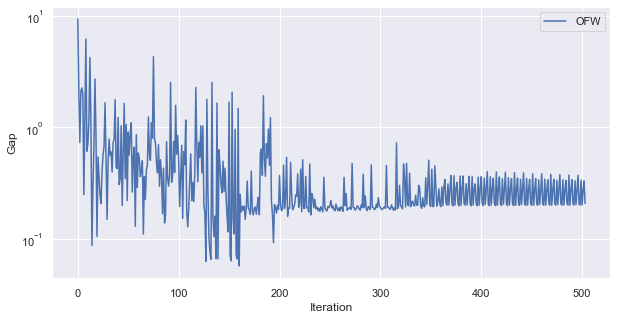

In [647]:
plt.figure(figsize=(10,5))
#plt.plot(obj_val[:,0][:-1],obj_val[:,2][:-1],label='DeFW')
plt.plot(obj_val[:,0][:-1],obj_val[:,2][:-1], label="OFW")
#plt.plot(gapf7,label="DMFW")
plt.ylabel("Gap")
plt.xlabel("Iteration")
plt.legend()
plt.yscale("log")
plt.show()

In [648]:
onlineloss = np.cumsum(obj_val[:,1][:-1])
arangement = np.arange(1,len(onlineloss)+1)
onlineloss = onlineloss/arangement

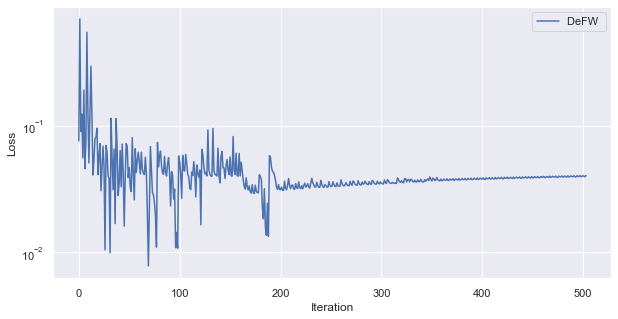

In [649]:
plt.figure(figsize=(10,5))
#plt.plot(obj_val[:,0][:-1],obj_val[:,1][:-1],label="DeFW")
plt.plot(obj_val[:,0][:-1],obj_val[:,1][:-1],label="DeFW ")
#plt.plot(onlineloss,label="De")
#plt.plot(onlineloss_dmfw,label="OFW Average Loss")
#plt.plot(lossesf7,label="DeMFW Loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.yscale("log")
plt.show()

In [650]:
def save_log_csv(log_file, path_to_save,algo,floor_idx,graph):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'{algo}_'+f'{floor_idx}_'+"_"+f'{graph}'+".csv"))

In [651]:
path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/Defw/lux/complete/"

In [652]:
save_log_csv(obj_val, path, "DeFW",str(floor),"complete")

In [149]:
def convert_loader_to_batch(dataloader, dates):
    mydict = {}
    t = 0
    for date in dates:
        for couple in dataloader[date]:
            mydict[t] = couple
            t+=1
    return mydict

In [54]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    try:
        prediction = []
        true = []
        assert(len(loader)>0)
        assert(date in loader.keys())
        # import pdb; pdb.set_trace()

        for val, valpred in loader[date]:
            
            model_to_test.eval()
            pred = model_to_test(val)
            #print(pred.shape)
            prediction.append(pred.detach().numpy())
            true.append(valpred.detach().numpy())
        pred_array = np.asarray(prediction)
        true_array = np.asarray(true)
        #print(pred_array.shape)
        pred_shape = pred_array.shape
        #print(pred_shape)
        flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
        flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
        return flattenTrue, flattenPred
    except:
        print (f"Data not found...Skipping Prediction for date {date}..")
        # import pdb;pdb.set_trace()
        return [],[]

In [407]:
true, pred, = ModelPrediction(trainer.models[0], "2019-08-09",testloder[0], lookahead)

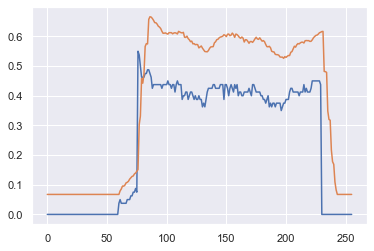

In [408]:
plt.plot(true)
plt.plot(pred)